# 기초 설정

In [51]:
#필요 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from sklearn.neural_network import MLPRegressor
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import accuracy_score

In [52]:
#데이터 불러오기
df = pd.read_csv('samsung.csv', index_col = 0) #encoding 지정으로 한글깨짐 방지, 일자를 인덱스로 사용

In [53]:
#인덱스 날자형으로 변경하기
df.index = pd.to_datetime(df.index)

In [54]:
df.head()

,시가,고가,저가,종가,거래량
일자,,,,,
2020-01-31,"57,800","58,400","56,400","56,400","19,749,457"
2020-01-30,"58,800","58,800","56,800","57,200","20,821,939"
2020-01-29,"59,100","59,700","58,800","59,100","16,446,102"
2020-01-28,"59,400","59,400","58,300","58,800","23,664,541"
2020-01-23,"61,800","61,800","60,700","60,800","14,916,555"


In [55]:
#문자형 데이터 수치형 데이터로 변환

for i in range(len(df)):   #데이터의 행 개수 
    for j in range(df.shape[1]): # 데이터의 열 개수
        df.iloc[i,j] = df.iloc[i,j].replace(',','') # 콤마 지우기(replace 함수)
        

for i in range(df.shape[1]): #데이터 열 개수만큼
    df.iloc[:,i] = df.iloc[:,i].astype('int') #열마다 데이터 수치형으로 변경

# 데이터 탐색

In [56]:
# 결측치 탐색
df.isnull().sum()

시가     0
고가     0
저가     0
종가     0
거래량    0
dtype: int64

In [57]:
# 시가, 고가, 저가, 종가, 거래량 기초통계량(평균, 분산, 최소, 최대 등)
df.describe()

,시가,고가,저가,종가,거래량
count,426.000000,426.000000,426.000000,426.000000,4.260000e+02
mean,46742.723005,47183.450704,46272.065728,46735.798122,1.143660e+07
std,4509.621724,4517.591974,4433.557218,4470.252415,5.072198e+06
min,37450.000000,37600.000000,36850.000000,37450.000000,4.406531e+06
25%,43912.500000,44350.000000,43550.000000,44000.000000,8.264758e+06
50%,46100.000000,46450.000000,45650.000000,46075.000000,1.043370e+07
75%,48975.000000,49237.500000,48537.500000,49012.500000,1.328609e+07
max,62000.000000,62800.000000,61700.000000,62400.000000,6.349111e+07


<AxesSubplot:xlabel='일자', ylabel='종가'>

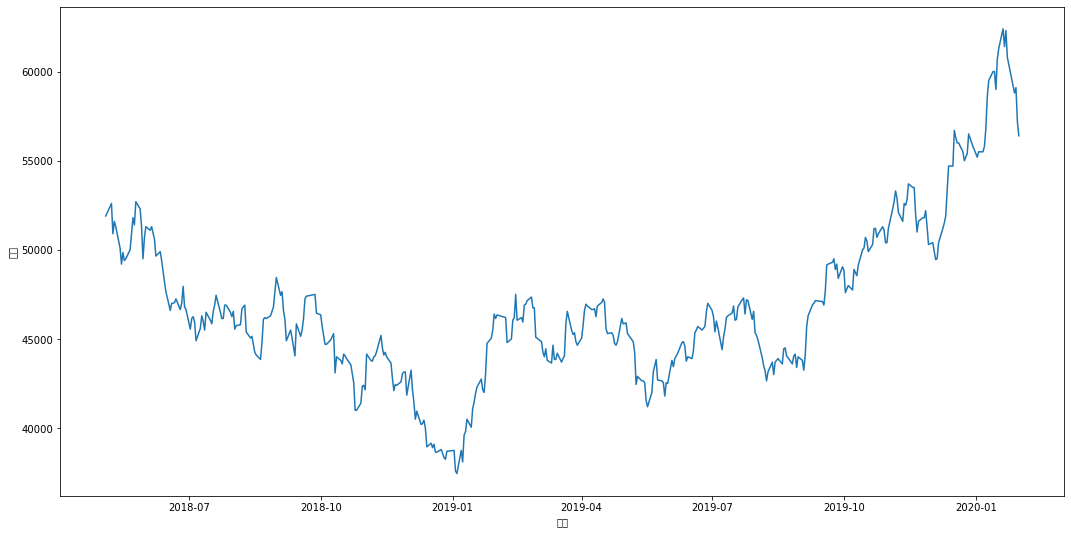

In [58]:
#종가
plt.figure(figsize=(18,9))
sns.lineplot(x=df.index, y=df['종가'])

# 주가지수 상승/하락 분류모형

In [59]:
#5_days ahead prediction(5영업일 이후 종가변수 추가)
df['5days'] = df['종가'].shift(7)

#7만큼 종가를 이전으로 가져왔기때문에 결측치 7개 존재
df = df.sort_index()
df.head(10)

,시가,고가,저가,종가,거래량,5days
일자,,,,,,
2018-05-04,53000,53900,51800,51900,39565391,49850.0
2018-05-08,52600,53200,51900,52600,23104720,49400.0
2018-05-09,52600,52800,50900,50900,16128305,49500.0
2018-05-10,51700,51700,50600,51600,13905263,50000.0
2018-05-11,52000,52200,51200,51300,10314997,51800.0
2018-05-14,51000,51100,49900,50100,14909272,51400.0
2018-05-15,50200,50400,49100,49200,18709146,52700.0
2018-05-16,49200,50200,49150,49850,15918683,52300.0
2018-05-17,50300,50500,49400,49400,10365440,51300.0


In [60]:
#결측치 제거
df = df.dropna()

In [61]:
#일주일 전 종가보다 올랐으면 1, 내렸으면 0으로 족속변수 설정
df['y'] = 0
df['y'] = np.where(df['5days'] > df['종가'], 1, 0)

In [62]:
#입력변수 설정(시가, 저가, 고가, 종가, 거래량)
X = df.drop(columns = 'y')
#종속변수 설정(5영업일 뒤 종가)
y = df['y']

In [63]:
#학습용, 검증용 데이터셋 나누기\
# (7:3, shuffle = False로 지정해 random sampling되지 않게 설정)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    shuffle=False)

In [64]:
#확인
print("학습 데이터 개수:", X_train.shape[0])
print("평가 데이터 개수:", X_test.shape[0])

학습 데이터 개수: 293
평가 데이터 개수: 126


# MA(5) 모형

In [65]:
#MA(5)예측값 생성 - 평가데이터 개수만큼
pred_MA = df['5days'].rolling(window = 5).mean()[293:]
pred_MA_class = pd.concat([X_test['5days'], pred_MA], axis = 1)
pred_MA_class.columns = ['real','prediction']
pred_MA_class['class'] = 0
pred_MA_class['class'] = np.where(pred_MA_class['real'] < pred_MA_class['prediction'], 1, 0)
pred_MA_class = pred_MA_class['class']
print('accuracy score:', round(accuracy_score(pred_MA_class, y_test) * 100,2))

accuracy score: 22.22


# 인공신경망 모형

In [66]:
train_X = X_train.drop(columns = '5days')
test_X = X_test.drop(columns = '5days')

In [67]:
#모형 생성
NN = MLPRegressor(hidden_layer_sizes = 10, #은닉층 노드 개수
                  momentum = 0.1, #모멘텀
                  learning_rate_init = 0.1, #학습률
                  max_iter = 1000, #epoch
                  random_state = 1) # 모형 고정

#모형 학습
NN.fit(train_X, y_train)

#예측 값 생성
pred_NN = pd.DataFrame(NN.predict(test_X))
pred_NN.columns = ['pred']
pred_NN.index = X_test.index
pred_NN_class = pd.concat([X_test['5days'], pred_NN], axis = 1)
pred_NN_class.columns = ['real','prediction']
pred_NN_class['class'] = 0
pred_NN_class['class'] = np.where(pred_NN_class['real'] < pred_NN_class['prediction'], 1, 0)
pred_NN_class = pred_NN_class['class']

print('accuracy score:', round(accuracy_score(pred_NN_class, y_test) * 100,2))

accuracy score: 38.1


# 순환 신경망 모형

In [68]:
#모형 구축
model = Sequential()
model.add(SimpleRNN(12, input_shape=(5,1), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['acc'])

In [69]:
#keras 입력값 형식 변경
train_x = train_X.values.reshape(train_X.shape[0],5,1) #행 길이, 변수 개수, 차원(1)
test_x = test_X.values.reshape(test_X.shape[0],5,1) 

In [70]:
#학습하기
epochs = 40
batch_size = 2
model.fit(train_x, y_train,
          batch_size=batch_size,
          epochs=epochs,
          shuffle=False)

Epoch 1/40
147/147 [==============================] - 0s 830us/step - loss: 1143573760.0000 - acc: 0.5119
Epoch 2/40
147/147 [==============================] - 0s 765us/step - loss: 683575552.0000 - acc: 0.4812
Epoch 3/40
147/147 [==============================] - 0s 821us/step - loss: 1001612288.0000 - acc: 0.5188
Epoch 4/40
147/147 [==============================] - 0s 803us/step - loss: 580689024.0000 - acc: 0.5427
Epoch 5/40
147/147 [==============================] - 0s 763us/step - loss: 411157184.0000 - acc: 0.4983
Epoch 6/40
147/147 [==============================] - 0s 769us/step - loss: 176821152.0000 - acc: 0.5290
Epoch 7/40
147/147 [==============================] - 0s 795us/step - loss: 24650874.0000 - acc: 0.5802
Epoch 8/40
147/147 [==============================] - 0s 776us/step - loss: 16390542.0000 - acc: 0.6246
Epoch 9/40
147/147 [==============================] - 0s 769us/step - loss: 750853.2500 - acc: 0.5768
Epoch 10/40
147/147 [==============================] - 0s 

In [71]:
pred_RNN = pd.DataFrame(model.predict(test_x))
pred_RNN.columns = ['pred']
pred_RNN.index = X_test.index
pred_RNN_class = pd.concat([X_test['5days'], pred_RNN], axis = 1)
pred_RNN_class.columns = ['real','prediction']
pred_RNN_class['class'] = 0
pred_RNN_class['class'] = np.where(pred_RNN_class['real'] < pred_RNN_class['prediction'], 1, 0)
pred_RNN_class = pred_RNN_class['class']

print('accuracy score:', round(accuracy_score(pred_RNN_class, y_test) * 100,2))

accuracy score: 38.1
